<a href="https://colab.research.google.com/github/dahouda2pro/Deep-Neural-Network-Using-BO/blob/main/Bayesian_Opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install GPy, GPyOpt
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
!pip install tensorflow-addons

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as K
import tensorflow_addons as tfa
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 32.1 MB/s 
     |████████████████████████████████| 71 kB 9.8 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp38-cp38-linux_x86_64.whl size=2842626 sha256=0d8ea9c94f216a69f082c5502284d8d5ff949c6ca23f8e8c67bf43e768873058
  Stored in directory: /root/.cache/pip/wheels/75/7c/1b/efc2b7349d76a79624df08d8e1c35eb33198b70f651a9d6ffd
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=55f1361ddb3867ba04f66782e9f29208cf29a9107e7b2e22352e0c7a9b0527ed
  Stored in directory: /root/.cache/pip/wheels/66/78/6c/d98cb437834de5e29381786b4ba8a77ea68cca74653ab62713
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 134 kB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.1-py3-none-any.whl size=73655 sha

In [ ]:
!python3 --version
#Python 3.6.9
print(tf.__version__)
#2.3.0
print(K.__version__)
#2.4.0
print(np.__version__)
#1.18.5
#print(matplotlib.__version__)
#3.2.2
print(GPy.__version__)
#1.9.8
print(GPyOpt.__version__)
#1.2.1

Python 3.8.15
2.9.2
2.9.0
1.21.6
1.9.8
1.2.1


In [ ]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [ ]:

# load the Cifar10 dataset, 50,000 training images and 10,000 test images (here used as validation data)
#(x_train, y_train), (x_test, y_test) = K.datasets.cifar100.load_data()
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)



num_classes = 10
input_shape = (32, 32, 3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [ ]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=num_classes)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

313/313 [==============================] - 40s 129ms/step


In [ ]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh', 4: 'sigmoid', 5: 'softplus'}
#activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh', 4: 'sigmoid', 5: 'softplus', 6: 'softsign', 7: 'selu'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=num_classes,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  model.compile(
           optimizer=K.optimizers.Adam(learning_rate=learning_rate),
           loss='categorical_crossentropy',
           metrics=['accuracy'])
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint

In [ ]:
def fit_model(model, lr_reduce, early_stop, checkpoint):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=32,
                      epochs=5,
                      verbose=1,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [ ]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation



Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 4.00e+00 5.00e-01]]
Epoch 1/50
1554/1563 [============================>.] - ETA: 0s - loss: 3.7228 - accuracy: 0.1161
Epoch 1: val_accuracy improved from -inf to 0.21560, saving model to cifar10.h5
1563/1563 [==============================] - 6s 3ms/step - loss: 3.7211 - accuracy: 0.1162 - val_loss: 3.1594 - val_accuracy: 0.2156 - lr: 1.0000e-06
Epoch 2/50
1561/1563 [============================>.] - ETA: 0s - loss: 3.2967 - accuracy: 0.1862
Epoch 2: val_accuracy improved from 0.21560 to 0.47120, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 3.2966 - accuracy: 0.1862 - val_loss: 2.8369 - val_accuracy: 0.4712 - lr: 1.0000e-06
Epoch 3/50
1550/1563 [============================>.] - ETA: 0s - loss: 2.9819 - accuracy: 0.2841
Epoch 3: val_accuracy improved from 0.47120 to 0.61830, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 2.9810 - accuracy: 0.2845 - 

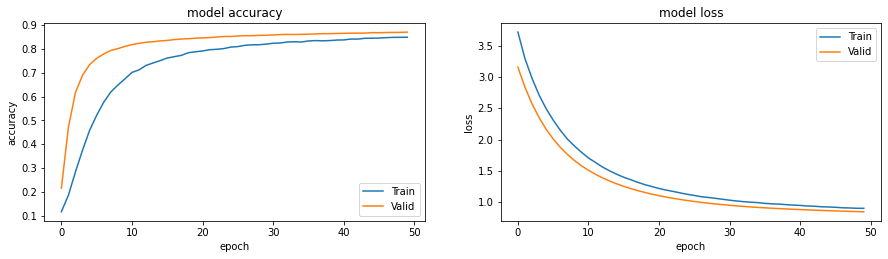


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 4.00e+00 2.50e-01]]
Epoch 1/50
1547/1563 [============================>.] - ETA: 0s - loss: 1.0730 - accuracy: 0.8225
Epoch 1: val_accuracy improved from -inf to 0.87980, saving model to cifar10.h5
1563/1563 [==============================] - 6s 3ms/step - loss: 1.0696 - accuracy: 0.8231 - val_loss: 0.7422 - val_accuracy: 0.8798 - lr: 1.0000e-04
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.8903
Epoch 2: val_accuracy improved from 0.87980 to 0.89260, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6799 - accuracy: 0.8903 - val_loss: 0.6320 - val_accuracy: 0.8926 - lr: 1.0000e-04
Epoch 3/50
1555/1563 [============================>.] - ETA: 0s - loss: 0.5813 - accuracy: 0.9001
Epoch 3: val_accuracy improved from 0.89260 to 0.89310, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5812 - accuracy: 0.9001 - 

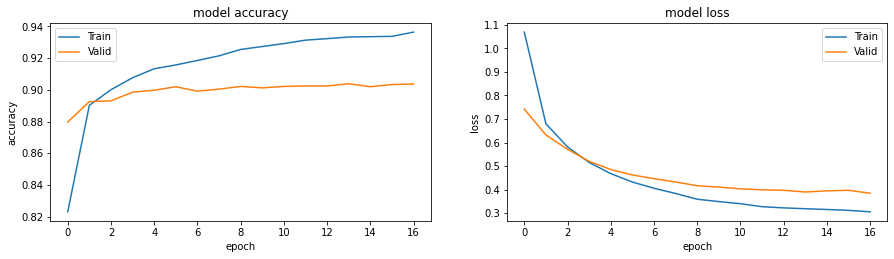


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 4.00e+00 2.50e-01]]
Epoch 1/50
1558/1563 [============================>.] - ETA: 0s - loss: 7.6526 - accuracy: 0.1292
Epoch 1: val_accuracy improved from -inf to 0.25490, saving model to cifar10.h5
1563/1563 [==============================] - 6s 3ms/step - loss: 7.6516 - accuracy: 0.1294 - val_loss: 7.2285 - val_accuracy: 0.2549 - lr: 1.0000e-06
Epoch 2/50
1557/1563 [============================>.] - ETA: 0s - loss: 7.1133 - accuracy: 0.2449
Epoch 2: val_accuracy improved from 0.25490 to 0.46300, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 7.1125 - accuracy: 0.2451 - val_loss: 6.7700 - val_accuracy: 0.4630 - lr: 1.0000e-06
Epoch 3/50
1559/1563 [============================>.] - ETA: 0s - loss: 6.6763 - accuracy: 0.3564
Epoch 3: val_accuracy improved from 0.46300 to 0.59230, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 6.6761 - accuracy: 0.3564 - 

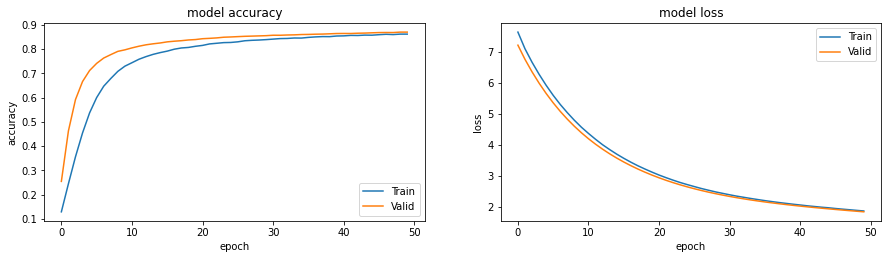


Hyperparameters: [[3.2e+01 1.0e-03 1.0e-03 2.0e+00 2.5e-01]]
Epoch 1/50
1551/1563 [============================>.] - ETA: 0s - loss: 0.7761 - accuracy: 0.7714
Epoch 1: val_accuracy improved from -inf to 0.86620, saving model to cifar10.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7744 - accuracy: 0.7718 - val_loss: 0.4440 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - ETA: 0s - loss: 0.4983 - accuracy: 0.8511
Epoch 2: val_accuracy improved from 0.86620 to 0.88070, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4983 - accuracy: 0.8511 - val_loss: 0.4053 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 3/50
1550/1563 [============================>.] - ETA: 0s - loss: 0.4537 - accuracy: 0.8664
Epoch 3: val_accuracy improved from 0.88070 to 0.88360, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4535 - accuracy: 0.8666 - val_loss: 0.3

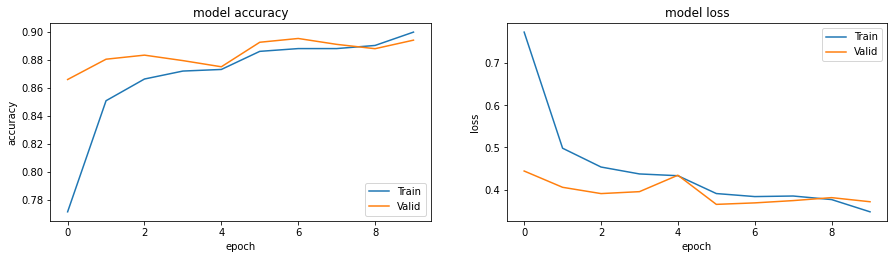


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 4.00e+00 5.00e-01]]
Epoch 1/50
1551/1563 [============================>.] - ETA: 0s - loss: 12.7881 - accuracy: 0.1296
Epoch 1: val_accuracy improved from -inf to 0.26760, saving model to cifar10.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 12.7852 - accuracy: 0.1297 - val_loss: 12.0419 - val_accuracy: 0.2676 - lr: 1.0000e-06
Epoch 2/50
1547/1563 [============================>.] - ETA: 0s - loss: 11.9918 - accuracy: 0.2004
Epoch 2: val_accuracy improved from 0.26760 to 0.48670, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 11.9881 - accuracy: 0.2007 - val_loss: 11.3186 - val_accuracy: 0.4867 - lr: 1.0000e-06
Epoch 3/50
1554/1563 [============================>.] - ETA: 0s - loss: 11.2776 - accuracy: 0.2920
Epoch 3: val_accuracy improved from 0.48670 to 0.62210, saving model to cifar10.h5
1563/1563 [==============================] - 5s 4ms/step - loss: 11.2761 - accuracy: 0

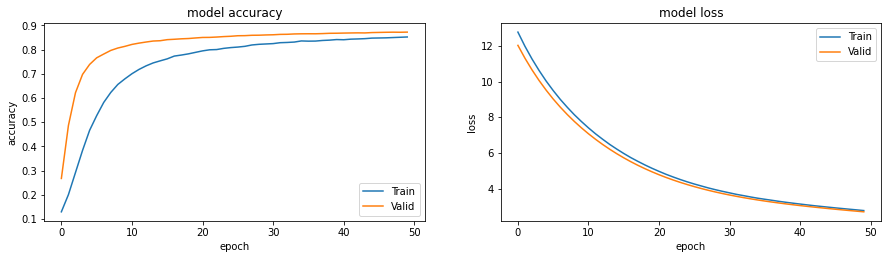




Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 2.0e+00 7.5e-01]]
Epoch 1/50
1554/1563 [============================>.] - ETA: 0s - loss: 8.3153 - accuracy: 0.1097
Epoch 1: val_accuracy improved from -inf to 0.14270, saving model to cifar10.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 8.3040 - accuracy: 0.1100 - val_loss: 3.7422 - val_accuracy: 0.1427 - lr: 1.0000e-06
Epoch 2/50
1561/1563 [============================>.] - ETA: 0s - loss: 6.0171 - accuracy: 0.1225
Epoch 2: val_accuracy improved from 0.14270 to 0.17770, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 6.0163 - accuracy: 0.1225 - val_loss: 3.0053 - val_accuracy: 0.1777 - lr: 1.0000e-06
Epoch 3/50
1555/1563 [============================>.] - ETA: 0s - loss: 4.8598 - accuracy: 0.1381
Epoch 3: val_accuracy improved from 0.17770 to 0.21210, saving model to cifar10.h5
1563/1563 [==============================] - 5s 3ms/step - loss: 4.8569 - accuracy: 0.1381 - val

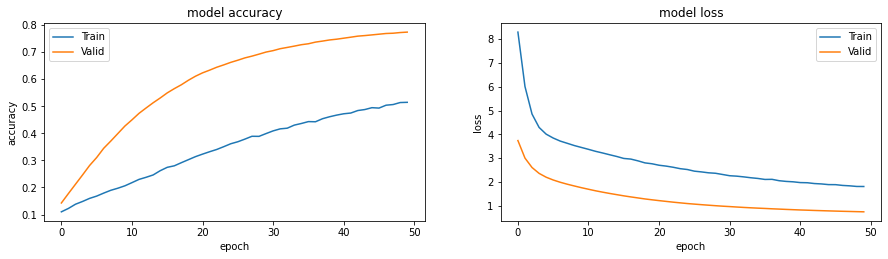


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 1.00e+00 2.50e-01]]
Epoch 1/50
1549/1563 [============================>.] - ETA: 0s - loss: 2.2245 - accuracy: 0.7163
Epoch 1: val_accuracy improved from -inf to 0.85460, saving model to cifar10.h5
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2180 - accuracy: 0.7171 - val_loss: 1.4002 - val_accuracy: 0.8546 - lr: 1.0000e-04
Epoch 2/50
1556/1563 [============================>.] - ETA: 0s - loss: 1.2530 - accuracy: 0.8501
Epoch 2: val_accuracy improved from 0.85460 to 0.87690, saving model to cifar10.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2522 - accuracy: 0.8501 - val_loss: 1.0256 - val_accuracy: 0.8769 - lr: 1.0000e-04
Epoch 3/50
1556/1563 [============================>.] - ETA: 0s - loss: 0.9274 - accuracy: 0.8742
Epoch 3: val_accuracy improved from 0.87690 to 0.88390, saving model to cifar10.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9273 - accuracy: 0.8741 - 

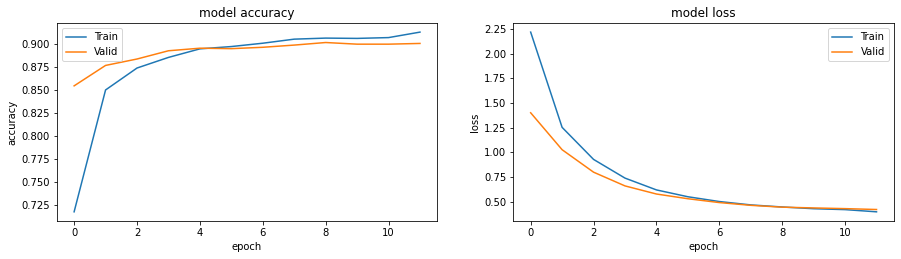

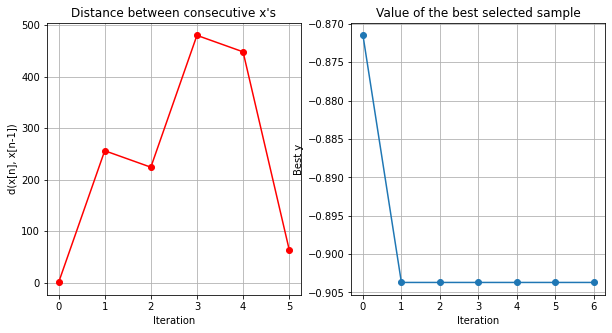

In [ ]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [
    {'name': 'units', 'type': 'discrete', 'domain': (32, 64, 128, 256, 512)}, 
    {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)}, 
    {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)}, 
    {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3, 4, 5)}, 
    {'name': 'rate', 'type': 'discrete', 'domain': (0.25, 0.5, 0.75)}]
# Note: 'activation' domain parameters (1, 2, 3, 4, 5, 6, 7) correspond to strings ('relu', 'elu', 'tanh','sigmoid', 'softplus', 'softsign', 'selu); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('cifar100_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],
  evaluation[1]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'cifar10_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'cifar10_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  plot = 0
  def plot_history(history):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plot = 0
    plt.savefig('Loss_Acc_'+str(plot)+'.pdf')
    plt.savefig('Loss_Acc_'+str(plot)+'.png')
    plot = plot + 1
    plt.show()
        
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=2, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [ ]:
# print optimized model
#activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh', 4: 'sigmoid', 5: 'softplus'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4]))
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	512.0
	learning_rate:	0.0001
	l2:	0.001
	activation:	sigmoid
	rate:	0.25

optimized accuracy: [0.90369999]


In [ ]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('cifar10_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 247,178
Trainable params: 247,178
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.4192 - accuracy: 0.9009
Restored model, accuracy: 90.09%


In [ ]:
best_model.evaluate(features_valid, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4192 - accuracy: 0.9009


[0.4192192852497101, 0.9009000062942505]

In [ ]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Tue Dec  6 06:10:22 2022
Optimization completed:      NO,7 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           415.9641845226288 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           5
Number continuous variables  0
Number discrete variables    5
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition opti

Configure the hyperparameters

In [ ]:
class Config:
    input_size = 32
    input_shape = [input_size, input_size, 3]
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_classes = 10
    num_epochs = 100
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

In [ ]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

In [ ]:
(train_data, train_labels),(test_data, test_labels)  = keras.datasets.cifar10.load_data()
(train_data.shape, train_labels.shape),(test_data.shape, test_labels.shape) 

170498071/170498071 [==============================] - 14s 0us/step


(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

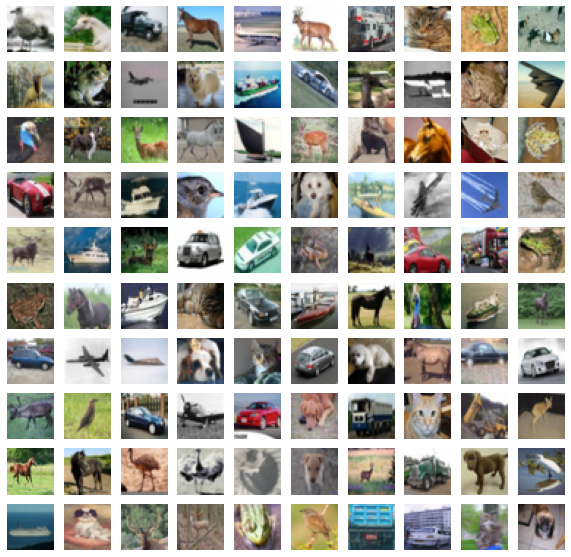

In [ ]:
indices = np.random.choice(train_data.shape[0], 100)
sample_images(train_data[indices], 10, 10)

 Use data augmentation

In [ ]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [ ]:
augmentation_layer.layers[0].adapt(train_data)

 Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Implement patch creation as a layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(32, 32, 3)
(1, 72, 72, 3)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


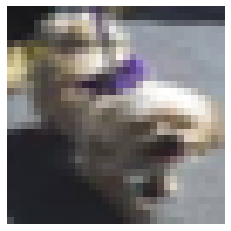

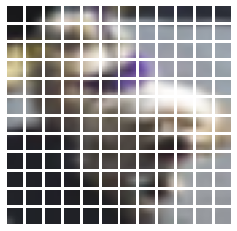

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = train_data[np.random.choice(range(train_data.shape[0]))]
print(image.shape)
plt.imshow(np.squeeze(image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
"""
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

"""
class PatchEncoder(layers.Layer):
    
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Build the ViT model

In [ ]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)
    
    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads, 
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = layers.Add()([attention_output, encoder_patches])
        
        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)
        
        # Skip Connnection 2
        encoder_patches = layers.Add()([x3, x2])
    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)
    
    outputs = layers.Dense(Config.num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Compile, train, and evaluate the model

In [ ]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 72, 72, 3)    7           ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 108)    0           ['sequential[0][0]']             
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches[0][0]']                
                                                                                              

In [ ]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
history = vit_classifier.fit(train_data, train_labels, verbose=1, epochs=30, batch_size=Config.batch_size, validation_data=(test_data, test_labels), callbacks=[checkpoint])

Epoch 1/30
196/196 [==============================] - 89s 394ms/step - loss: 2.0068 - accuracy: 0.3255 - val_loss: 1.4620 - val_accuracy: 0.4865
Epoch 2/30
196/196 [==============================] - 76s 387ms/step - loss: 1.5121 - accuracy: 0.4587 - val_loss: 1.2232 - val_accuracy: 0.5515
Epoch 3/30
196/196 [==============================] - 76s 386ms/step - loss: 1.3525 - accuracy: 0.5209 - val_loss: 1.1405 - val_accuracy: 0.6024
Epoch 4/30
196/196 [==============================] - 76s 386ms/step - loss: 1.2448 - accuracy: 0.5562 - val_loss: 1.0528 - val_accuracy: 0.6316
Epoch 5/30
196/196 [==============================] - 76s 387ms/step - loss: 1.1778 - accuracy: 0.5877 - val_loss: 1.0103 - val_accuracy: 0.6411
Epoch 6/30
196/196 [==============================] - 76s 386ms/step - loss: 1.1169 - accuracy: 0.6068 - val_loss: 0.9694 - val_accuracy: 0.6616
Epoch 7/30
196/196 [==============================] - 75s 384ms/step - loss: 1.0602 - accuracy: 0.6260 - val_loss: 0.9621 - val_ac

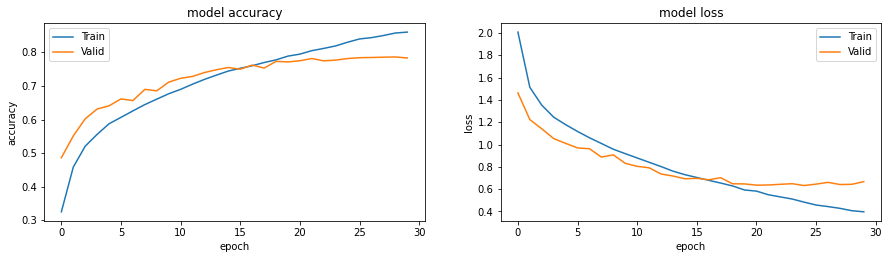

In [ ]:
  # print(history_dict)
plot = 0
def plot_history(history):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plot = 0
    plt.savefig('Loss_Acc_'+str(plot)+'.pdf')
    plt.savefig('Loss_Acc_'+str(plot)+'.png')
    plot = plot + 1
    plt.show()
        
  # plot the model accuracy and loss results
plot_history(history)